<a href="https://colab.research.google.com/github/xharles2994/Tensorflow_models/blob/main/Title_Multiclass_Semantic_Segmentation_of_Minerals_in_Soil_Samples_using_U_NeT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Title: Multiclass Semantic Segmentation of Minerals in Soil Samples using U-Net with MobileVNet Backbone

##Table of Contents:

1. Introduction

2. Problem Statement

3. Method

 3.1 Dataset Preparation

 3.2 Model Architecture

 3.3 Training and Evaluation

4. Results and Analysis

5. Conclusion and Future Work

6. References (if applicable)


##2. Problem Statement:

Introduction:
Soil samples contain various minerals that play a crucial role in determining soil fertility and health. Accurate identification and mapping of these minerals in soil samples can aid in understanding soil composition, nutrient availability, and potential agricultural productivity. Semantic segmentation, a pixel-level image analysis technique, can be employed to accurately identify and map different minerals in soil samples. In this project, we propose to use a U-Net model for the task of multiclass semantic segmentation of minerals in soil samples.

Objective:
The objective of this project is to develop a robust and accurate multiclass semantic segmentation model using U-Net for identifying and mapping different minerals in soil samples. The model will be trained on a large dataset of soil sample images broken down into 1600 patches of size 128x128 pixels. The goal is to achieve high accuracy in mineral identification and mapping, enabling further analysis of soil composition and properties.







In [ ]:
from tensorflow.keras.utils import get_custom_objects

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Dependencies 



In [ ]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

###Dataset Preparation: 
The dataset will be collected, consisting of soil sample images with corresponding masks containing annotations for different mineral (7) classes, such as clay and other minerals. The dataset will be divided into training, validation, and testing sets, and images will be broken down into 1600 patches of size 128x128 pixels for training efficiency.

In [ ]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=7 #Number of classes for segmentation
num_images = 1600  #Total 1600 available
num_channels = 1 #black and white image 

In [ ]:
#Image processing 
image_names = glob.glob("/content/drive/MyDrive/PORTFOLIO/Dataset/UNET/Segmentation_dATASET/Images/*.jpg")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 0) for image in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis=3)  # Add an additional axis for num_channels
image_dataset = np.expand_dims(image_dataset, axis=0)  # Add an additional axis for number of images
image_dataset = np.squeeze(image_dataset, axis=0)  # Remove the first axis

In [ ]:
#Mask Processing
mask_names = glob.glob("/content/drive/MyDrive/PORTFOLIO/Dataset/UNET/Segmentation_dATASET/mask/*.jpg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1600, 128, 128, 1)
Mask data shape is:  (1600, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5 6]


In [ ]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(1600, 128, 128, 1)


Normalize the image dataset for the for the Unet model

In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [ ]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
print(y_train_cat.shape)

(1280, 128, 128, 7)


In [ ]:
print("Image data shape is: ", y_train_cat.shape)
print("Image data shape is: ", y_test_cat.shape)

Image data shape is:  (1280, 128, 128, 7)
Image data shape is:  (320, 128, 128, 7)


###Model Architecture:
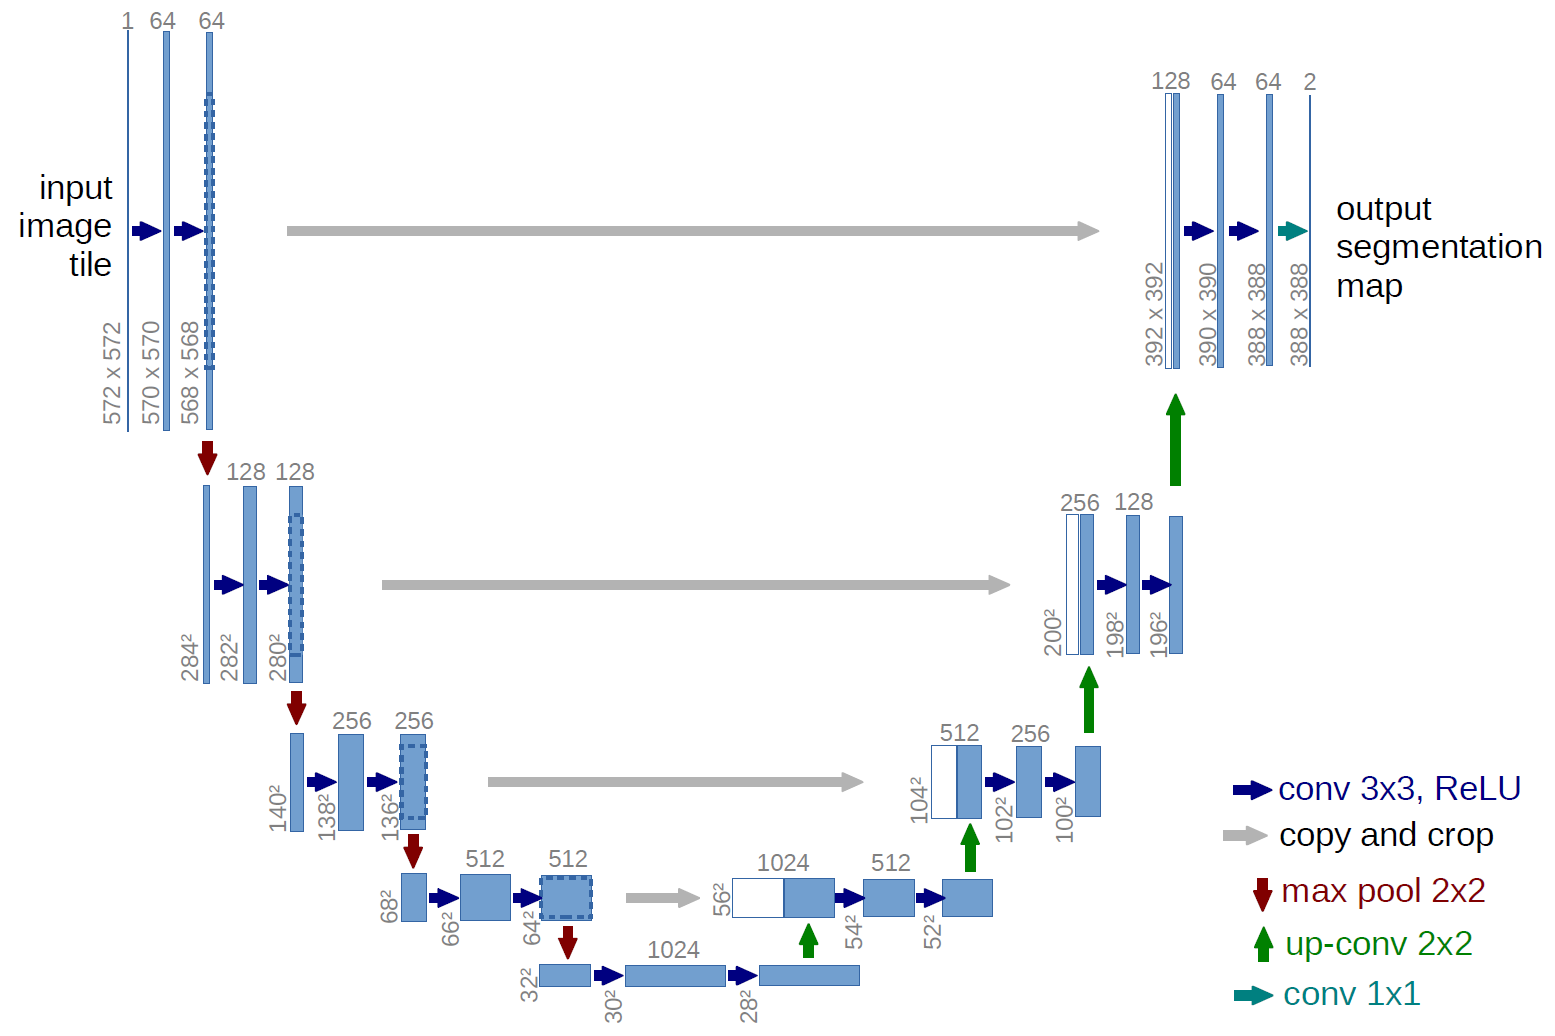

U-Net will be used as the model for semantic segmentation. The U-Net architecture with skip connections helps capture both local and global contextual information, while the backbone provides a lightweight and efficient feature extraction process, suitable for processing large datasets. The model will be trained using TensorFlow library

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 128, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                     

###Training and Evaluation:
The model will be trained using the training set and validated using the validation set. The training process will involve optimizing hyperparameters, such as learning rate, batch size, and data augmentation techniques to achieve the best performance. The model will be evaluated using metrics such as accuracy and loss.

In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/50
80/80 [==============================] - 35s 263ms/step - loss: 0.6151 - accuracy: 0.8719 - val_loss: 1.5507 - val_accuracy: 0.7297
Epoch 2/50
80/80 [==============================] - 20s 254ms/step - loss: 0.2403 - accuracy: 0.9310 - val_loss: 0.9871 - val_accuracy: 0.7671
Epoch 3/50
80/80 [==============================] - 20s 247ms/step - loss: 0.1994 - accuracy: 0.9346 - val_loss: 1.0251 - val_accuracy: 0.7957
Epoch 4/50
80/80 [==============================] - 21s 257ms/step - loss: 0.1845 - accuracy: 0.9367 - val_loss: 1.1695 - val_accuracy: 0.7865
Epoch 5/50
80/80 [==============================] - 22s 271ms/step - loss: 0.1750 - accuracy: 0.9384 - val_loss: 1.1213 - val_accuracy: 0.8022
Epoch 6/50
80/80 [==============================] - 21s 263ms/step - loss: 0.1682 - accuracy: 0.9398 - val_loss: 0.9278 - val_accuracy: 0.8112
Epoch 7/50
80/80 [==============================] - 21s 264ms/step - loss: 0.1629 - accuracy: 0.9410 - val_loss: 0.5879 - val_accuracy: 0.8450

###Save model and Analyze results:
The results of the trained model will be presented, showcasing the accuracy and efficiency of the proposed U-Net for multiclass semantic segmentation of minerals in soil samples.

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/PORTFOLIO/Dataset/UNET/Segmentation_dATASET/Saved_models/multiclassoilsample1.hdf5')

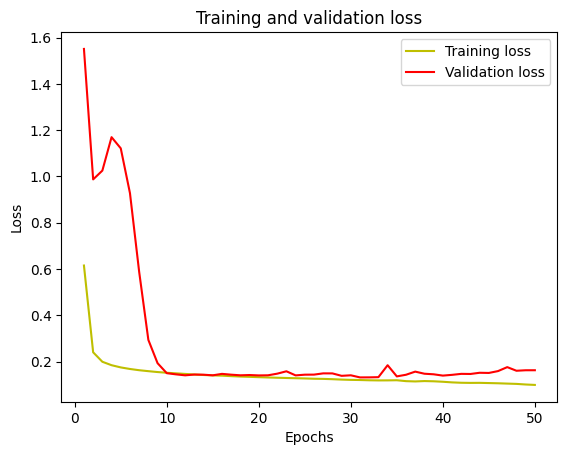

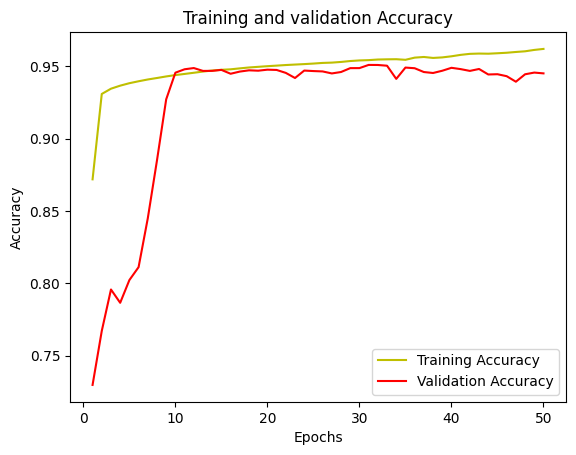

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/PORTFOLIO/Dataset/UNET/Segmentation_dATASET/Saved_models/multiclassoilsample1.hdf5", compile=False)

In [ ]:
y_pred=model.predict(X_test)

10/10 [==============================] - 2s 144ms/step


In [ ]:
y_pred.shape

(320, 128, 128, 7)

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(320, 128, 128)

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 7
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.53805405


###Conclusion

1/1 [==============================] - 0s 403ms/step


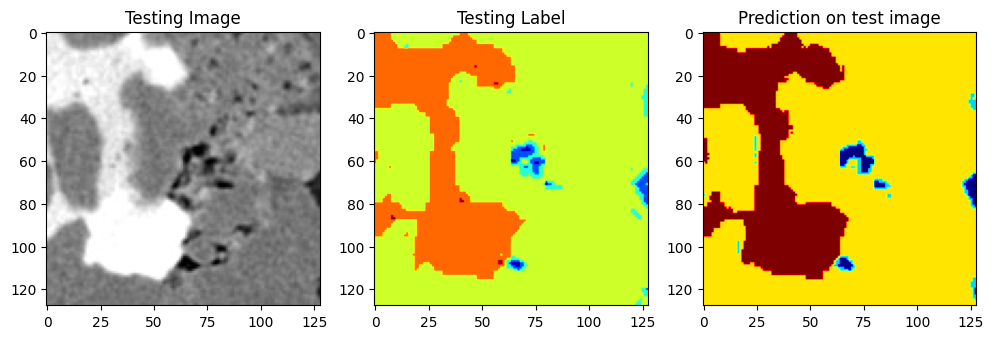

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()